In [8]:
%matplotlib inline
import nltk
import numpy as np
import pandas as pd
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [11]:
titles = open('titles.txt').read().split('\n')
synopses = open('synopses.txt').read().split('\n BREAKS HERE')
synopses = synopses[:100]
print(len(titles)) # output = 100
print(len(synopses)) # output = 100

100
100


In [24]:
stemmer = SnowballStemmer("english")

def tokenize_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text)
                    for word in nltk.word_tokenize(sent)]
    final_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            final_tokens.append(token)

    stems = [stemmer.stem(t) for t in final_tokens]
    return stems

In [29]:
stopwords = nltk.corpus.stopwords.words("english")

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000, max_df=0.8, min_df=0.2,stop_words='english', tokenizer=tokenize_stem)
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
print(tfidf_matrix.shape) # output = (100, 548)
terms = tfidf_vectorizer.get_feature_names()
print(terms)

(100, 548)
["'d", 'abandon', 'abl', 'accept', 'accid', 'accompani', 'accus', 'act', 'action', 'actual', 'admit', 'afterward', 'ago', 'agre', 'air', 'aliv', 'allow', 'alon', 'alreadi', 'alway', 'american', 'angri', 'angrili', 'ani', 'announc', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar', 'appear', 'approach', 'area', 'argu', 'arm', 'armi', 'arrang', 'arrest', 'arriv', 'ask', 'assign', 'assist', 'assum', 'attack', 'attempt', 'attend', 'attent', 'attract', 'audienc', 'avoid', 'away', 'bad', 'bar', 'bare', 'battl', 'beat', 'becaus', 'becom', 'bed', 'beg', 'believ', 'best', 'better', 'big', 'black', 'blow', 'board', 'bodi', 'book', 'boss', 'boy', 'break', 'brief', 'bring', 'broken', 'brother', 'build', 'burn', 'busi', 'buy', 'ca', 'camp', 'captain', 'captur', 'car', 'care', 'career', 'carri', 'case', 'catch', 'caus', 'chanc', 'chang', 'charg', 'chase', 'child', 'children', 'citi', 'claim', 'clear', 'climb', 'close', 'cloth', 'club', 'cold', 'collaps', 'come', 'command', 'commit', 

In [49]:
km = KMeans(n_clusters = 5)
km.fit(tfidf_matrix) # K-means clustering 적용
clusters = km.labels_.tolist() # 리스트화
print(clusters)
len(clusters)

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


100

In [34]:
films = {'title': titles, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index=clusters, columns=['title', 'cluster'])
frame['cluster'].value_counts() # 각 클러스터의 영화 개수 출력

4    38
2    31
1    16
3    11
0     4
Name: cluster, dtype: int64

In [37]:
print("Top terms per cluster:\n\n")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    print("Cluster %d words:" % i, end='')
    for j in range(5):
        print(terms[order_centroids[i][j]], end=',')
    print('\n')
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print('\n')

Top terms per cluster:


Cluster 0 words:georg,marri,famili,jame,john,

Cluster 0 titles: It's a Wonderful Life, The Philadelphia Story, The King's Speech, A Place in the Sun,

Cluster 1 words:soldier,armi,kill,command,general,

Cluster 1 titles: Casablanca, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Braveheart, Platoon, Dances with Wolves, All Quiet on the Western Front,

Cluster 2 words:famili,war,new,home,father,

Cluster 2 titles: The Godfather, Schindler's List, Gone with the Wind, Citizen Kane, Titanic, The Godfather: Part II, Forrest Gump, The Sound of Music, Amadeus, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, High No

In [38]:
#set up colors per clusters using a dict
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange'}

#set up cluster names using a dict
cluster_names = {0: 'Kill, Solider, Army',
                 1: 'Sing, Love, Relationship',
                 2: 'Car, Drive, Train',
                 3: 'Family, Home, Brother',
                 4: 'Marry, Woman, Friend'}

In [40]:
dist = 1 - cosine_similarity(tfidf_matrix) # distance equation
mds = MDS(n_components=2, dissimilarity = 'precomputed')
Z = mds.fit_transform(dist) # 2차원으로 축소
xs, ys = Z[:, 0], Z[:, 1] # 시각화를 위해 저장해둔

In [42]:
df = pd.DataFrame(dict(x = xs, y = ys, label=clusters, title=titles))
groups = df.groupby('label') 

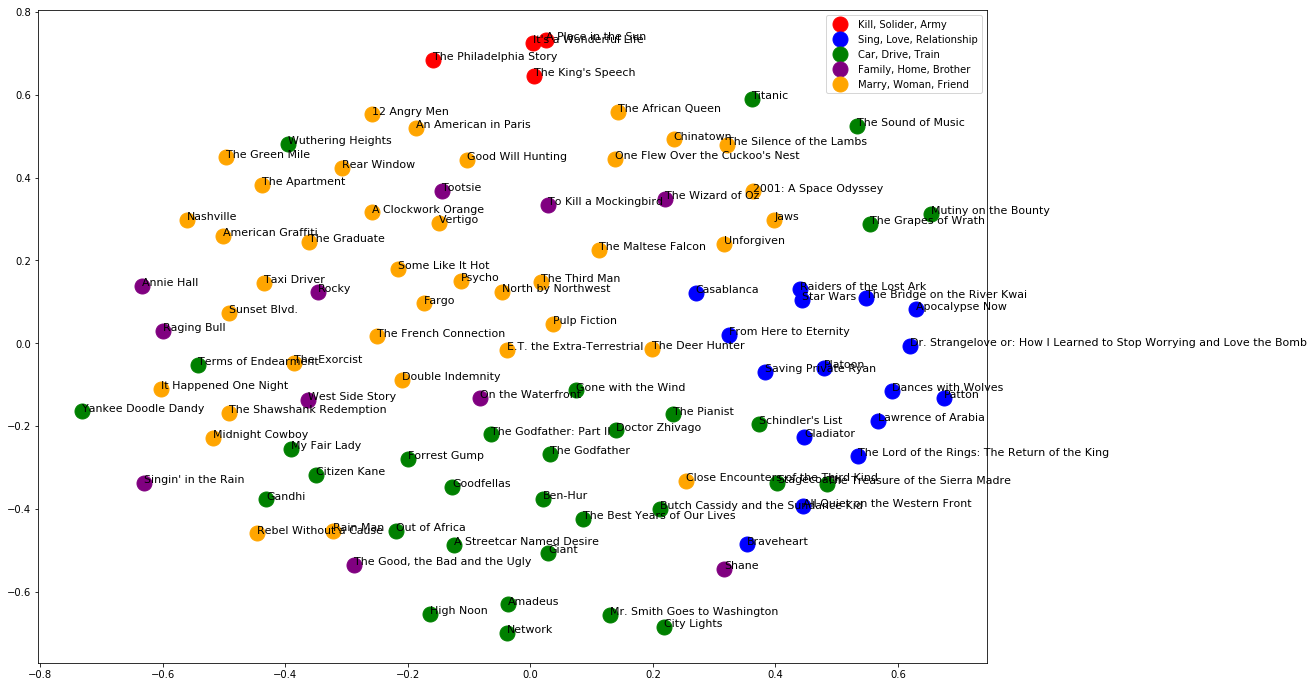

In [48]:
fig, ax = plt.subplots(figsize=(17, 12)) # set size

for idx, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=15, label=cluster_names[idx], color=cluster_colors[idx])
    
ax.legend(numpoints=1) #show legend with only 1 point
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size = 11)
plt.show()